In [872]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import math

warnings.simplefilter(action='ignore', category=FutureWarning)

In [873]:
def applica_strategia(btc_data, 
                      percentuale_sbilanciamento_acquisti=0.7, 
                      percentuale_sbilanciamento_vendite=0.7,
                      percentuale_primo_acquisto=0.01, 
                      percentuale_prima_vendita=0.01,
                      liquidità_iniziale=1000, 
                      bitcoin_iniziali=0, 
                      percentuale_commissione_acquisti=0.001, 
                      percentuale_commissione_vendite=0.001,
                      acquisto_minimo=1, 
                      vendita_minima=1,
                      vendi_pure=False,
                      compra_pure=False,
                      soglia_minima_vendita=0.05):
    
    # Inizializzazione delle variabili
    liquidità = liquidità_iniziale
    bitcoin = bitcoin_iniziali
    valore_portafoglio = []
    transazioni = []

    # Variabili di controllo
    ultima_azione = None
    ultimo_prezzo_acquisto = 0
    ultimo_prezzo_vendita = 0
    somme_acquisto = 0
    somme_vendita = 0
    pesi_acquisto = 0
    pesi_vendita = 0

    # Nuove variabili per il calcolo del prezzo medio pesato
    acquisti_consecutivi = []
    prezzo_medio_pesato = 0

    for i in range(1, len(btc_data)):
        azione = "-"
        # ultima_azione = '-'
        quantità_euro = 0
        quantità_bitcoin = 0
        prezzo_oggi = btc_data['Price'][i]
        prezzo_ieri = btc_data['Price'][i-1]
        data = btc_data['Timestamp'][i]

        liquidità_precedente = liquidità
        bitcoin_precedenti = bitcoin

        def esegui_acquisto():
            nonlocal quantità_euro, quantità_bitcoin, liquidità, bitcoin, azione, ultima_azione, ultimo_prezzo_acquisto, somme_acquisto, pesi_acquisto, acquisti_consecutivi, prezzo_medio_pesato
            if quantità_euro >= acquisto_minimo and quantità_euro != 0:
                if quantità_euro > liquidità and compra_pure:
                    quantità_euro = liquidità
                    quantità_bitcoin = (quantità_euro / prezzo_oggi) * (1 - percentuale_commissione_acquisti)
                    bitcoin += quantità_bitcoin
                    liquidità -= quantità_euro
                    azione = "acquisto"
                    ultima_azione = "acquisto"
                    ultimo_prezzo_acquisto = prezzo_oggi
                    somme_acquisto += prezzo_oggi * quantità_euro
                    pesi_acquisto += quantità_euro
                    acquisti_consecutivi.append((prezzo_oggi, quantità_euro))
                    prezzo_medio_pesato = sum(p*q for p, q in acquisti_consecutivi) / sum(q for _, q in acquisti_consecutivi)
                elif quantità_euro <= liquidità:
                    quantità_bitcoin = (quantità_euro / prezzo_oggi) * (1 - percentuale_commissione_acquisti)
                    bitcoin += quantità_bitcoin
                    liquidità -= quantità_euro
                    azione = "acquisto"
                    ultima_azione = "acquisto"
                    ultimo_prezzo_acquisto = prezzo_oggi
                    somme_acquisto += prezzo_oggi * quantità_euro
                    pesi_acquisto += quantità_euro
                    acquisti_consecutivi.append((prezzo_oggi, quantità_euro))
                    prezzo_medio_pesato = sum(p*q for p, q in acquisti_consecutivi) / sum(q for _, q in acquisti_consecutivi)

        def esegui_vendita():
            nonlocal quantità_euro, quantità_bitcoin, liquidità, bitcoin, azione, ultima_azione, ultimo_prezzo_vendita, somme_vendita, pesi_vendita, acquisti_consecutivi, prezzo_medio_pesato
            if quantità_euro >= vendita_minima and quantità_euro != 0:
                if quantità_bitcoin > bitcoin and vendi_pure and prezzo_oggi >= prezzo_medio_pesato * (1 + soglia_minima_vendita):
                    quantità_bitcoin = bitcoin
                    quantità_euro = quantità_bitcoin * prezzo_oggi * (1 - percentuale_commissione_vendite)
                    bitcoin -= quantità_bitcoin
                    liquidità += quantità_euro
                    azione = "vendita"
                    ultima_azione = "vendita"
                    ultimo_prezzo_vendita = prezzo_oggi
                    somme_vendita += prezzo_oggi * quantità_euro
                    pesi_vendita += quantità_euro
                    acquisti_consecutivi = []
                elif quantità_bitcoin <= bitcoin and prezzo_oggi >= prezzo_medio_pesato * (1 + soglia_minima_vendita):
                    if quantità_euro > 0 and quantità_bitcoin > 0:
                        bitcoin -= quantità_bitcoin
                        liquidità += quantità_euro
                        azione = "vendita"
                        ultima_azione = "vendita"
                        ultimo_prezzo_vendita = prezzo_oggi
                        somme_vendita += prezzo_oggi * quantità_euro
                        pesi_vendita += quantità_euro
                        acquisti_consecutivi = []

        if ultima_azione is None:  # Caso del primo giorno
            if prezzo_oggi < prezzo_ieri:  # Il prezzo è sceso
                quantità_euro = liquidità * percentuale_primo_acquisto
                esegui_acquisto()
            elif prezzo_oggi > prezzo_ieri:  # Il prezzo è salito
                quantità_bitcoin = bitcoin * percentuale_prima_vendita
                quantità_euro = quantità_bitcoin * prezzo_oggi
                esegui_vendita()

        else:  # Dopo il primo giorno
            if ultima_azione == "acquisto" and prezzo_oggi < ultimo_prezzo_acquisto:
                A = percentuale_sbilanciamento_acquisti * prezzo_oggi + (1 - percentuale_sbilanciamento_acquisti) * ultimo_prezzo_acquisto
                quantità_euro = (somme_acquisto - A * pesi_acquisto) / (A - prezzo_oggi)
                esegui_acquisto()
            elif ultima_azione == "vendita" and prezzo_oggi > ultimo_prezzo_vendita:
                A = percentuale_sbilanciamento_vendite * prezzo_oggi + (1 - percentuale_sbilanciamento_vendite) * ultimo_prezzo_vendita
                quantità_euro = (somme_vendita - A * pesi_vendita) / (A - prezzo_oggi)
                quantità_bitcoin = (quantità_euro / prezzo_oggi)
                esegui_vendita()
            elif ultima_azione == "acquisto" and prezzo_oggi > ultimo_prezzo_acquisto:
                # Cambio di direzione: si vende dopo un acquisto
                quantità_bitcoin = percentuale_prima_vendita * bitcoin
                quantità_euro = quantità_bitcoin * prezzo_oggi
                esegui_vendita()
            elif ultima_azione == "vendita" and prezzo_oggi < ultimo_prezzo_vendita:
                # Cambio di direzione: si compra dopo una vendita
                quantità_euro = percentuale_primo_acquisto * liquidità
                esegui_acquisto()

        valore_totale = liquidità + bitcoin * prezzo_oggi
        valore_portafoglio.append(valore_totale)
        
        transazioni.append({
            'data': data,
            'prezzo': prezzo_oggi,
            'azione': azione,
            'ultima azione': ultima_azione,
            'percentuale_liquidità_usata': round((quantità_euro / liquidità_precedente) * 100, 2) if azione == "acquisto" and liquidità_precedente != 0 else 0,
            'percentuale_token_venduti': round((quantità_bitcoin / bitcoin_precedenti) * 100, 2) if azione == "vendita" and bitcoin_precedenti != 0 else 0,
            'quantità_euro': quantità_euro,
            'quantità_bitcoin': quantità_bitcoin,
            'liquidità_posseduta': liquidità,
            'bitcoin_posseduti': bitcoin,
            'valore_totale_portafoglio': valore_totale
        })

    return pd.DataFrame(transazioni)

In [874]:
# Funzione per calcolare la dimensione dei punti nel grafico
def calcola_dimensione(quantita, max_quantita, min_size=20, max_size=200):
    return min_size + (max_size - min_size) * (quantita / max_quantita)

In [875]:
# Funzione per plottare il grafico delle transazioni
def plot_transazioni(dati, transazioni, etichette=True):
    acquisti = transazioni[transazioni['azione'] == 'acquisto']
    vendite = transazioni[transazioni['azione'] == 'vendita']

    # Calcolo delle dimensioni dei punti
    max_acquisto = acquisti['quantità_euro'].max() if not acquisti.empty else 0
    max_vendita = vendite['quantità_euro'].max() if not vendite.empty else 0

    dimensioni_acquisti = acquisti['quantità_euro'].apply(lambda x: calcola_dimensione(x, max_acquisto)) if max_acquisto > 0 else []
    dimensioni_vendite = vendite['quantità_euro'].apply(lambda x: calcola_dimensione(x, max_vendita)) if max_vendita > 0 else []

    # Creazione del grafico
    plt.figure(figsize=(20, 14))
    plt.grid()
    plt.plot(dati['Timestamp'], dati['Price'], label='Prezzi')
    if not acquisti.empty:
        plt.scatter(acquisti['data'], acquisti['prezzo'], s=dimensioni_acquisti, color='green', alpha=0.6, label='Acquisti')
        if etichette:
            for i, row in acquisti.iterrows():
                plt.text(row['data'], row['prezzo'], f"+{row['quantità_euro']:.2f} €", 
                         color='black', ha='center', va='bottom')
    if not vendite.empty:
        plt.scatter(vendite['data'], vendite['prezzo'], s=dimensioni_vendite, color='red', alpha=0.6, label='Vendite')
        if etichette:
            for i, row in vendite.iterrows():
                plt.text(row['data'], row['prezzo'], f"-{row['quantità_euro']:.2f} €", 
                         color='black', ha='center', va='top')

    plt.xlabel('Data')
    plt.ylabel('Prezzo')
    plt.title('Andamento dei prezzi e transazioni')
    plt.legend()
    plt.show()

### Lettura dati

In [876]:
dati = pd.read_csv('Bitcoin (€) da yfinance dal 17-09-2014 al 24-04-2024.csv')
dati = dati[['Date', 'Close']]
dati = dati.rename(columns = {'Date':'Timestamp', 'Close': 'Price'})
dati['Timestamp'] = pd.to_datetime(dati['Timestamp'])
dati['Timestamp'] = dati['Timestamp'].dt.strftime('%Y-%m-%d')
dati['Timestamp'] = pd.to_datetime(dati['Timestamp'], format='%Y-%m-%d')
dati

,Timestamp,Price
0,2014-09-17,355.957367
1,2014-09-18,328.539368
2,2014-09-19,307.761139
3,2014-09-20,318.758972
4,2014-09-21,310.632446
...,...,...
3503,2024-04-20,59876.710938
3504,2024-04-21,60956.074219
3505,2024-04-22,60919.242188
3506,2024-04-23,62729.296875


In [877]:
# dati = pd.read_csv('Bitcoin (€) da yfinance dal 06-05-2022 alle 21 al 05-05-2024 alle 19 con granularità oraria.csv')
# dati = dati[['Datetime', 'Close']]
# dati = dati.rename(columns = {'Datetime':'Timestamp', 'Close': 'Price'})
# dati['Timestamp'] = pd.to_datetime(dati['Timestamp'])
# dati['Timestamp'] = dati['Timestamp'].dt.strftime('%Y-%m-%d %H')
# dati['Timestamp'] = pd.to_datetime(dati['Timestamp'], format='%Y-%m-%d %H')
# dati

In [878]:
data_inizio = '2023-01-01'
data_fine = '2023-04-01'
indice_inizio = dati[dati['Timestamp'] == data_inizio].index[0]
indice_fine = dati[dati['Timestamp'] == data_fine].index[0]
dati = dati[indice_inizio:indice_fine + 1].reset_index(drop=True)
dati

,Timestamp,Price
0,2023-01-01,15528.423828
1,2023-01-02,15630.739258
2,2023-01-03,15817.341797
3,2023-01-04,15899.841797
4,2023-01-05,16002.543945
...,...,...
86,2023-03-28,25114.818359
87,2023-03-29,25156.841797
88,2023-03-30,26145.060547
89,2023-03-31,25708.375000


In [879]:
# data_inizio = '2023-06-01 00'
# data_fine = '2023-12-01 00'
# indice_inizio = dati[dati['Timestamp'] == data_inizio].index[0]
# indice_fine = dati[dati['Timestamp'] == data_fine].index[0]
# dati = dati[indice_inizio:indice_fine + 1].reset_index(drop=True)
# dati

### Eventuale cambio dati

In [880]:
def calcola_prezzo(t):
    return dati['Price'][t] #1000 - t + 100 * math.sin(2*math.pi * t / 4)

In [881]:
dati['Price'] = dati.index.map(calcola_prezzo)
dati

,Timestamp,Price
0,2023-01-01,15528.423828
1,2023-01-02,15630.739258
2,2023-01-03,15817.341797
3,2023-01-04,15899.841797
4,2023-01-05,16002.543945
...,...,...
86,2023-03-28,25114.818359
87,2023-03-29,25156.841797
88,2023-03-30,26145.060547
89,2023-03-31,25708.375000


In [882]:
percentuale_sbilanciamento_acquisti=0.1
percentuale_sbilanciamento_vendite=0.1
percentuale_primo_acquisto=0.1
percentuale_prima_vendita=0.1
vendi_pure=True
compra_pure=True
soglia_minima_vendita = 0

liquidità_iniziale=1000
bitcoin_iniziali=0
percentuale_commissione_acquisti=0.001
percentuale_commissione_vendite=0.001
acquisto_minimo=0
vendita_minima=0

# Applica la strategia
df_transazioni = applica_strategia(dati, 
                      percentuale_sbilanciamento_acquisti, 
                      percentuale_sbilanciamento_vendite,
                      percentuale_primo_acquisto, 
                      percentuale_prima_vendita,
                      liquidità_iniziale, 
                      bitcoin_iniziali, 
                      percentuale_commissione_acquisti, 
                      percentuale_commissione_vendite,
                      acquisto_minimo,
                      vendita_minima,
                      vendi_pure,
                      compra_pure,
                      soglia_minima_vendita)

# Visualizza il valore del portafoglio nel tempo
df_transazioni['valore_totale_portafoglio']

0     1000.000000
1     1000.000000
2     1000.000000
3     1000.000000
4      999.900000
         ...     
85    1100.366334
86    1100.550287
87    1104.340530
88    1104.230096
89    1106.362100
Name: valore_totale_portafoglio, Length: 90, dtype: float64

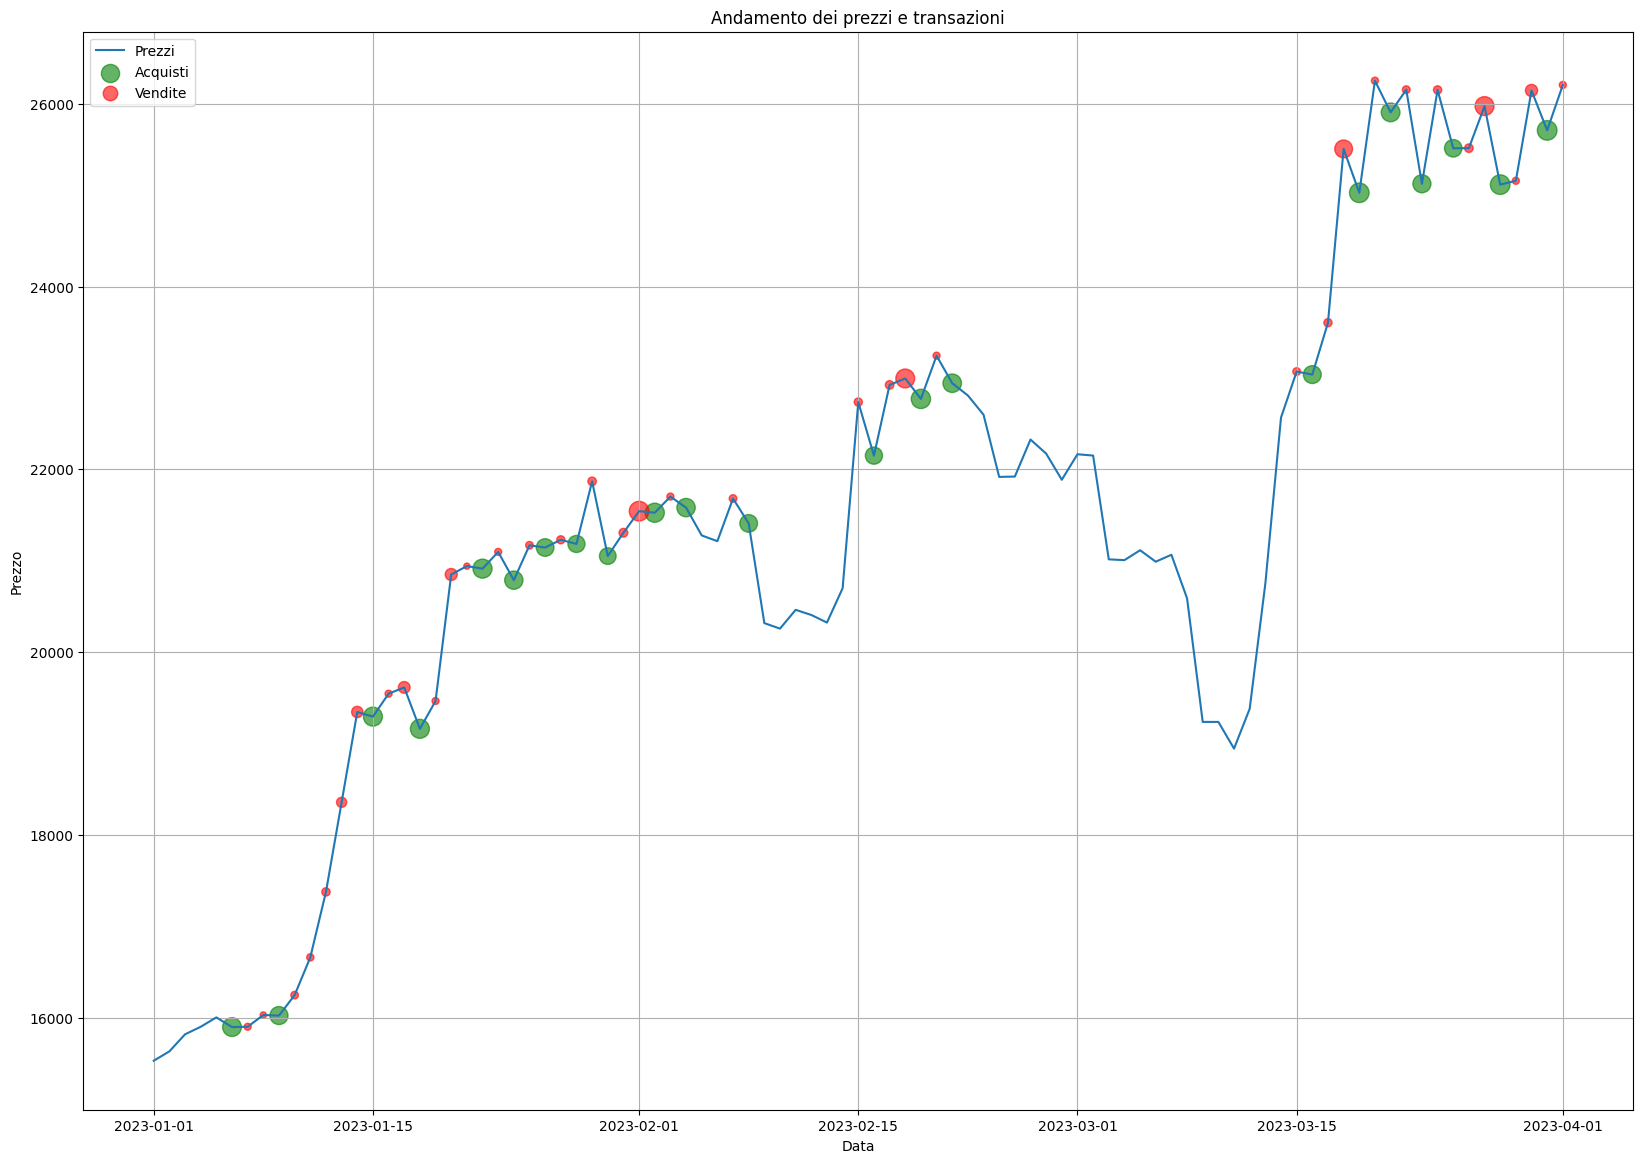

In [883]:
# Plotta il grafico delle transazioni
plot_transazioni(dati, df_transazioni, etichette=False)

In [884]:
df_transazioni[:60]

,data,prezzo,azione,ultima azione,percentuale_liquidità_usata,percentuale_token_venduti,quantità_euro,quantità_bitcoin,liquidità_posseduta,bitcoin_posseduti,valore_totale_portafoglio
0,2023-01-02,15630.739258,-,None,0.0,0.00,0.000000,0.000000,1000.000000,0.000000,1000.000000
1,2023-01-03,15817.341797,-,None,0.0,0.00,0.000000,0.000000,1000.000000,0.000000,1000.000000
2,2023-01-04,15899.841797,-,None,0.0,0.00,0.000000,0.000000,1000.000000,0.000000,1000.000000
3,2023-01-05,16002.543945,-,None,0.0,0.00,0.000000,0.000000,1000.000000,0.000000,1000.000000
4,2023-01-06,15896.708984,acquisto,acquisto,10.0,0.00,100.000000,0.006284,900.000000,0.006284,999.900000
5,2023-01-07,15900.098633,vendita,vendita,0.0,10.00,9.992130,0.000628,909.992130,0.005656,999.921302
6,2023-01-08,16028.553711,vendita,vendita,0.0,1.22,1.110237,0.000069,911.102367,0.005587,1000.647829
7,2023-01-09,16022.666016,acquisto,acquisto,10.0,0.00,91.110237,0.005681,819.992130,0.011267,1000.523827
8,2023-01-10,16246.458984,vendita,vendita,0.0,10.00,18.305323,0.001127,838.297453,0.010141,1003.045362
9,2023-01-11,16659.367188,vendita,vendita,0.0,7.83,13.231544,0.000794,851.528997,0.009346,1007.232475


In [885]:
def calcola_rendimento_portafoglio_ideale(capitale_iniziale, bitcoin_iniziali, lista_prezzi, min_acquisto, min_vendita, perc_commissione_acquisto, perc_commissione_vendita):
    capitale = capitale_iniziale
    bitcoin = bitcoin_iniziali
    comprato = False

    for i in range(len(lista_prezzi) - 1):
        # Compra al minimo
        if lista_prezzi[i] < lista_prezzi[i + 1] and not comprato and capitale >= min_acquisto:
            bitcoin_acquistati = (capitale * (1 - perc_commissione_acquisto)) / lista_prezzi[i]
            bitcoin += bitcoin_acquistati
            capitale = 0
            comprato = True
            # print(f'Bitcoin posseduti: {bitcoin}')
        # Vende al massimo
        elif lista_prezzi[i] > lista_prezzi[i + 1] and comprato and bitcoin * lista_prezzi[i] >= min_vendita:
            capitale_vendita = bitcoin * lista_prezzi[i] * (1 - perc_commissione_vendita)
            capitale += capitale_vendita
            bitcoin = 0
            comprato = False
            # print(f'Capitale posseduto: {capitale}')

    # Vende i bitcoin rimasti all'ultimo prezzo
    if comprato and bitcoin * lista_prezzi.iloc[-1] >= min_vendita:
        capitale += bitcoin * lista_prezzi.iloc[-1] * (1 - perc_commissione_vendita)
        bitcoin = 0
        # print(f'Capitale posseduto: {capitale}')
        # print(f'Bitcoin posseduti: {bitcoin}')

    valore_iniziale = capitale_iniziale + bitcoin_iniziali * lista_prezzi[0]
    valore_finale = capitale + bitcoin * lista_prezzi.iloc[-1]

    rendimento = valore_finale / valore_iniziale

    return [rendimento, valore_finale]

In [886]:
rendimento_ideale, portafoglio_finale_ideale = calcola_rendimento_portafoglio_ideale(liquidità_iniziale, bitcoin_iniziali, dati['Price'], acquisto_minimo, vendita_minima, percentuale_commissione_acquisti, percentuale_commissione_vendite)
print('Rendimento ideale:', rendimento_ideale)
print('Portafoglio finale ideale in euro:', portafoglio_finale_ideale)

Rendimento ideale: 2.9611826189001755
Portafoglio finale ideale in euro: 2961.1826189001754


In [887]:
valore_iniziale = liquidità_iniziale + bitcoin_iniziali * dati['Price'][0]
valore_finale = df_transazioni['liquidità_posseduta'].iloc[-1] + df_transazioni['bitcoin_posseduti'].iloc[-1] * dati['Price'].iloc[-1]
rendimento = valore_finale / valore_iniziale

In [888]:
print(f"Rendimento del portafoglio: {rendimento}")
print(f'Punteggio rendimento: {round(rendimento / rendimento_ideale *100, 2)}%')
print(f"Valore finale del portafoglio in euro: {df_transazioni['liquidità_posseduta'].iloc[-1] + df_transazioni['bitcoin_posseduti'].iloc[-1] * dati['Price'].iloc[-1]}")

Rendimento del portafoglio: 1.1063621003235786
Punteggio rendimento: 37.36%
Valore finale del portafoglio in euro: 1106.3621003235787
